##Brain Tumor Detection
Kaggle: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

In [15]:
### Data Cleaning
# Remove if folder exist already
!rm -rf BrainTumor

In [16]:
!apt-get update
!apt-get install -y p7zip-full
!7z x BrainTumor.zip -oBrainTumor


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [17]:
import os
# List the contents of the extracted directory to show its structure
extract_path = 'BrainTumor'
print(f"Directory tree for: {extract_path }")
for root, dirs, files in os.walk(extract_path ):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')


Directory tree for: BrainTumor
BrainTumor/
    Training/
        notumor/
        meningioma/
        glioma/
        pituitary/
    Testing/
        notumor/
        meningioma/
        glioma/
        pituitary/


In [18]:
# It is found to have duplications in dataset downloaded from Kaggle
# so we will check their hash values to remove duplications.
import os
import hashlib

LABELS = ['glioma', 'meningioma','notumor', 'pituitary']

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        hasher.update(f.read())
    return hasher.hexdigest()

def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(extract_path, data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.lower().endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        hash_dict.setdefault(file_hash, []).append(file_path)

def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, paths in hash_dict.items():
        if len(paths) > 1:
            for p in paths[1:]:  # keep first, delete others
                os.remove(p)
                duplicate_count += 1
    print("Total duplicates removed:", duplicate_count)

hash_dict = {}
list_files(hash_dict)
remove_duplicates(hash_dict)


Total duplicates removed: 297


In [19]:
# Count remaining images
from collections import defaultdict

def count_images():
    count_dict = defaultdict(int)

    for split in ["Training", "Testing"]:
        print(f"\n{split}:")
        for label in LABELS:
            folder = os.path.join(extract_path, split, label)
            if os.path.exists(folder):
                num = len([f for f in os.listdir(folder) if f.endswith(".jpg")])
                count_dict[(split, label)] = num
                print(f"\t{label}: {num} images")
            else:
                print(f"Folder missing: {folder}")

    return count_dict

counts = count_images()


Training:
	glioma: 1321 images
	meningioma: 1333 images
	notumor: 1422 images
	pituitary: 1445 images

Testing:
	glioma: 299 images
	meningioma: 302 images
	notumor: 309 images
	pituitary: 295 images


In [20]:
# Rebalance and split dataset Train/Val/Test into 80/10/10
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd

ROOT = Path("BrainTumor")
NEW_ROOT = Path("BrainTumor_80_10_10")   # new clean dataset

# Classes (exact folder names in dataset)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# 1. Collect all image paths + labels
data = []

for split in ['Training', 'Testing']:
    for cls in classes:
        folder = ROOT / split / cls
        for img_file in folder.glob("*.jpg"):
            data.append({'path': str(img_file), 'label': cls})

df = pd.DataFrame(data)
print(f"Total images found: {len(df)}")   # should print 6726

# 2. Stratified 80/10/10 split
X = df['path']
y = df['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, stratify=y_train_val, random_state=42)

# 3. Copy to new folder structure
def copy_split(paths, labels, split_name):
    split_folder = NEW_ROOT / split_name
    for cls in classes:
        (split_folder / cls).mkdir(parents=True, exist_ok=True)

    for p, label in zip(paths, labels):
        dest = split_folder / label / Path(p).name
        shutil.copy2(p, dest)

copy_split(X_train, y_train, "train")
copy_split(X_val,   y_val,   "val")
copy_split(X_test,  y_test,  "test")

# 4. Print final counts
print("\nFinal 80/10/10 split:")
print("Train :", len(X_train))
print("Val   :", len(X_val))
print("Test  :", len(X_test))
for cls in classes:
    print(f"{cls:11} → train:{(y_train==cls).sum():4}  val:{(y_val==cls).sum():3}  test:{(y_test==cls).sum():3}")

Total images found: 6726

Final 80/10/10 split:
Train : 5380
Val   : 673
Test  : 673
glioma      → train:1296  val:162  test:162
meningioma  → train:1307  val:164  test:164
notumor     → train:1385  val:173  test:173
pituitary   → train:1392  val:174  test:174



Showing 3 samples per class from "Training" dataset...



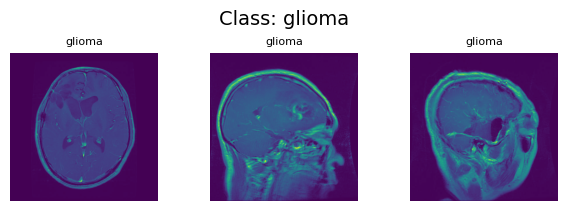

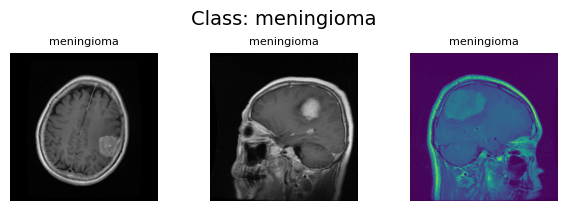

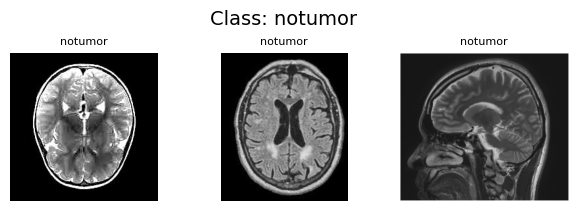

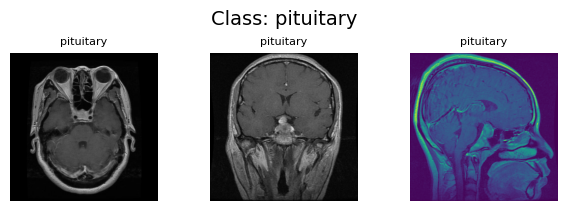

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

def show_samples(split):
    print(f"\nShowing 3 samples per class from \"{split}\" dataset...\n")

    num_samples = 3

    for label in LABELS:
        folder = os.path.join(extract_path, split, label)

        if not os.path.exists(folder):
            print(f"Folder not found: {folder}")
            continue

        imgs = [os.path.join(folder, f) for f in os.listdir(folder)
                if f.lower().endswith(".jpg")]

        if len(imgs) < 3:
            print(f"Not enough images in {folder}")
            continue

        selected_imgs = random.sample(imgs, num_samples)

        # Smaller figure + spaced layout
        plt.figure(figsize=(6, 2), constrained_layout=True)
        plt.suptitle(f"Class: {label}", fontsize=14)

        for i, img_path in enumerate(selected_imgs):
            img = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(label, fontsize=8)

        plt.show()

        # Add extra blank space between rows
        print("\n" * 2)


show_samples(split="Training")

In [22]:
### Data Preprocessing: resize, flip, norm
import torch
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader

IMG_SIZE = 224  # 224x224
SEED = 42
BATCH_SIZE = 32

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # ensure 3 channels
    transforms.Resize((IMG_SIZE, IMG_SIZE)),       # resize all images
    transforms.RandomHorizontalFlip(p=0.5),       # randomly flip horizontally
    transforms.RandomRotation(degrees=10),        # rotate randomly ± degrees
    transforms.RandomApply([transforms.ColorJitter(
        brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8),
    transforms.ToTensor(),                         # convert to tensor
    normalize
])

# For validation, test, we don't do data augmentation
test_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # ensure 3 channels
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize
])

# Loading data into memory
train_path = "BrainTumor_80_10_10/train"
val_path = "BrainTumor_80_10_10/val"
test_path  = "BrainTumor_80_10_10/test"

train_set = datasets.ImageFolder(root=train_path, transform=train_transform)
val_set = datasets.ImageFolder(root=val_path, transform=test_transform)
test_set = datasets.ImageFolder(root=test_path, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Class to index mapping:", train_set.class_to_idx)
print(f"Training samples  : {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Testing samples   : {len(test_set)}")

Class to index mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Training samples  : 5380
Validation samples: 673
Testing samples   : 673


In [23]:
# Use GPU if it is available
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Define Basic CNN Model

In [24]:
import torch
import torch.nn as nn

class BaselineCNN(nn.Module):
    def __init__(self, num_classes=4):   # 4 classes
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14

            nn.AdaptiveAvgPool2d((1, 1))  # Global Avg Pool
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 4)          # num_classes
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineCNN(num_classes=4).to(device)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

BaselineCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool

Defined hyperparameters

Training Loop

In [26]:
import time
import copy

def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30, patience=7):
    print(f"\n{'='*10} Training {model_name} {'='*10}")

    # Track metrics
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    trigger_times = 0

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)

        # --- Validation Phase ---
        model.eval()
        val_running_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)

        # Update History
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Scheduler Step
        if scheduler:
            scheduler.step(val_acc)

        # Logging
        print(f"Epoch {epoch+1:02d}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early Stopping & Checkpointing
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best weights before returning
    model.load_state_dict(best_model_wts)
    print(f"Best Val Acc for {model_name}: {best_val_acc:.4f}")
    return history

In [27]:
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18, ResNet18_Weights

# 1. Setup Baseline
model_baseline = BaselineCNN(num_classes=4).to(device)
optimizer_base = torch.optim.Adam(model_baseline.parameters(), lr=0.001, weight_decay=1e-3)
scheduler_base = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_base, mode='max', patience=3, factor=0.5)

# 2. Setup ResNet18
model_resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 4)
model_resnet = model_resnet.to(device)

optimizer_res = torch.optim.Adam(model_resnet.parameters(), lr=0.001, weight_decay=1e-3)
scheduler_res = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_res, mode='max', patience=3, factor=0.5)

# 3. Train Both
# Using the same criterion for fair comparison
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

history_baseline = train_model(
    model_baseline, "BaselineCNN",
    train_loader, val_loader,
    criterion, optimizer_base, scheduler_base, device
)

history_resnet = train_model(
    model_resnet, "ResNet18",
    train_loader, val_loader,
    criterion, optimizer_res, scheduler_res, device
)


========== Training BaselineCNN ==========
Epoch 01/30 | Train Acc: 0.5775 | Val Acc: 0.4042 | LR: 0.001000
Epoch 02/30 | Train Acc: 0.6526 | Val Acc: 0.6850 | LR: 0.001000
Epoch 03/30 | Train Acc: 0.6781 | Val Acc: 0.4695 | LR: 0.001000
Epoch 04/30 | Train Acc: 0.7074 | Val Acc: 0.5260 | LR: 0.001000
Epoch 05/30 | Train Acc: 0.7426 | Val Acc: 0.7860 | LR: 0.001000
Epoch 06/30 | Train Acc: 0.7790 | Val Acc: 0.6285 | LR: 0.001000
Epoch 07/30 | Train Acc: 0.7868 | Val Acc: 0.7875 | LR: 0.001000
Epoch 08/30 | Train Acc: 0.7903 | Val Acc: 0.6523 | LR: 0.001000
Epoch 09/30 | Train Acc: 0.7916 | Val Acc: 0.8514 | LR: 0.001000
Epoch 10/30 | Train Acc: 0.8126 | Val Acc: 0.8544 | LR: 0.001000
Epoch 11/30 | Train Acc: 0.8188 | Val Acc: 0.8276 | LR: 0.001000
Epoch 12/30 | Train Acc: 0.8154 | Val Acc: 0.8455 | LR: 0.001000
Epoch 13/30 | Train Acc: 0.8273 | Val Acc: 0.7786 | LR: 0.001000
Epoch 14/30 | Train Acc: 0.8355 | Val Acc: 0.7712 | LR: 0.000500
Epoch 15/30 | Train Acc: 0.8667 | Val Acc: 0.7

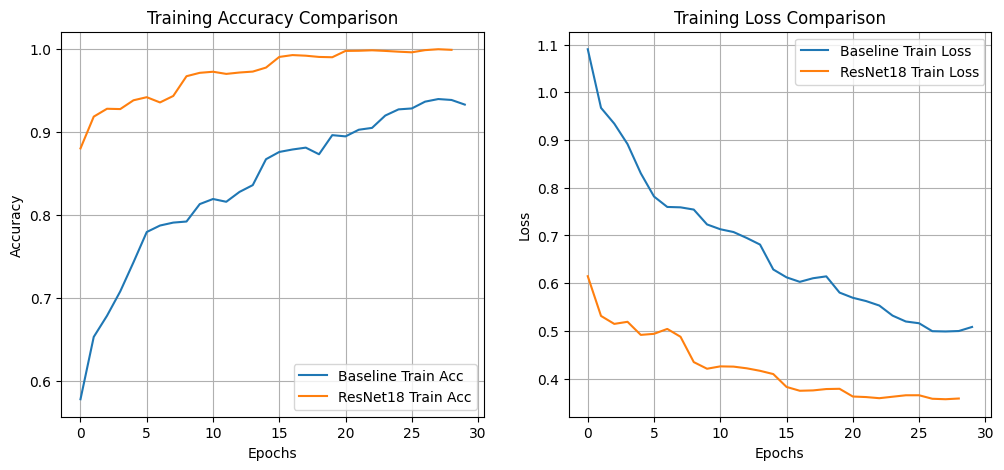

In [35]:
plt.figure(figsize=(12, 5))

# Plot Testing Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_baseline['train_acc'], label='Baseline Train Acc')
plt.plot(history_resnet['train_acc'], label='ResNet18 Train Acc')
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history_baseline['train_loss'], label='Baseline Train Loss')
plt.plot(history_resnet['train_loss'], label='ResNet18 Train Loss')
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

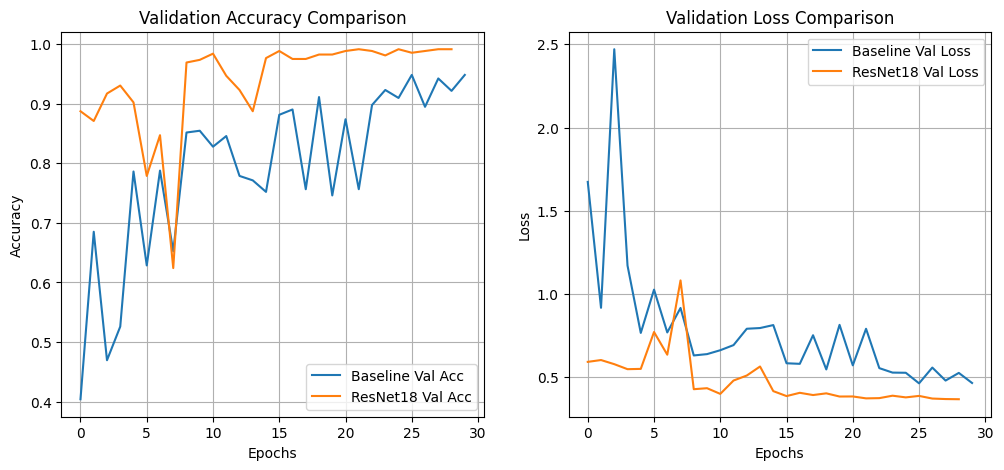

In [36]:
plt.figure(figsize=(12, 5))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_baseline['val_acc'], label='Baseline Val Acc')
plt.plot(history_resnet['val_acc'], label='ResNet18 Val Acc')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_baseline['val_loss'], label='Baseline Val Loss')
plt.plot(history_resnet['val_loss'], label='ResNet18 Val Loss')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

Testing accuracy

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

def evaluate_model(model, test_loader, device, class_names, model_name="Model"):
    print(f"\n{'='*10} Evaluating {model_name} {'='*10}")

    # 1. Set to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []

    # 2. Iterate over test data
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 3. Calculate Accuracy
    test_acc = accuracy_score(all_labels, all_preds)
    print(f"FINAL TEST ACCURACY for {model_name}: {test_acc:.4f}")

    # 4. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix (Acc: {test_acc:.4f})")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # 5. Print Classification Report
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return test_acc


========== Evaluating Baseline CNN ==========
FINAL TEST ACCURACY for Baseline CNN: 0.9376


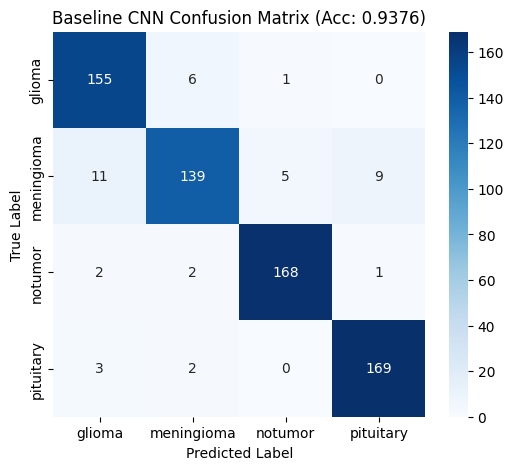


Classification Report (Baseline CNN):
              precision    recall  f1-score   support

      glioma       0.91      0.96      0.93       162
  meningioma       0.93      0.85      0.89       164
     notumor       0.97      0.97      0.97       173
   pituitary       0.94      0.97      0.96       174

    accuracy                           0.94       673
   macro avg       0.94      0.94      0.94       673
weighted avg       0.94      0.94      0.94       673


========== Evaluating ResNet18 ==========
FINAL TEST ACCURACY for ResNet18: 0.9851


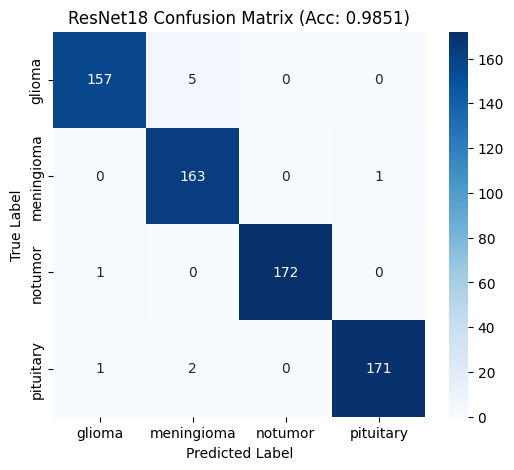


Classification Report (ResNet18):
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       162
  meningioma       0.96      0.99      0.98       164
     notumor       1.00      0.99      1.00       173
   pituitary       0.99      0.98      0.99       174

    accuracy                           0.99       673
   macro avg       0.99      0.99      0.98       673
weighted avg       0.99      0.99      0.99       673



0.9851411589895989

In [31]:
# Get class names
class_names = train_set.classes

# --- Evaluate Baseline CNN ---
# Load the best weights saved during training
model_baseline.load_state_dict(torch.load('BaselineCNN_best.pth'))
evaluate_model(model_baseline, test_loader, device, class_names, model_name="Baseline CNN")

# --- Evaluate ResNet18 ---
# Load the best weights saved during training
model_resnet.load_state_dict(torch.load('ResNet18_best.pth'))
evaluate_model(model_resnet, test_loader, device, class_names, model_name="ResNet18")

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_image(tensor):
    """Helper to convert tensor to valid image for plotting"""
    img = tensor.numpy().transpose(1, 2, 0)
    # Normalize to [0, 1] range for display
    img = (img - img.min()) / (img.max() - img.min())
    return img

def visualize_errors(model, test_loader, device, class_names, model_name="Model"):
    print(f"\n{'='*10} Analyzing Misclassifications: {model_name} {'='*10}")

    # 1. Setup container for errors
    misclassified = {cls: [] for cls in class_names}

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get probabilities
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            # Loop over batch to find errors
            for img, true_label, pred_label, prob_vec in zip(inputs, labels, preds, probs):
                if true_label != pred_label:
                    pred_prob = prob_vec[pred_label].item()
                    true_prob = prob_vec[true_label].item()
                    wrongness = pred_prob - true_prob   # larger = confident but wrong

                    cls_name = class_names[true_label.cpu().item()]
                    misclassified[cls_name].append({
                        "img": img.cpu(),
                        "true": true_label.cpu().item(),
                        "pred": pred_label.cpu().item(),
                        "pred_prob": pred_prob,
                        "true_prob": true_prob,
                        "wrongness": wrongness
                    })

    # 2. Sort errors by "wrongness"
    for cls in misclassified:
        misclassified[cls] = sorted(
            misclassified[cls],
            key=lambda x: x["wrongness"],
            reverse=True
        )

    # 3. Plot top 3 errors per class
    for cls in class_names:
        errors = misclassified[cls][:3]  # top 3 worst mistakes

        if len(errors) == 0:
            print(f"Good news! No misclassified images for class: {cls}")
            continue

        # Create a figure for this class
        plt.figure(figsize=(10, 3))
        plt.suptitle(f"[{model_name}] Worst Errors for Class: {cls}", fontsize=14, y=1.05)

        for i, err in enumerate(errors):
            plt.subplot(1, 3, i+1)
            plt.imshow(show_image(err["img"]))
            plt.axis("off")

            true_name = class_names[err['true']]
            pred_name = class_names[err['pred']]

            plt.title(
                f"True: {true_name}\n"
                f"Pred: {pred_name}\n"
                f"Conf: {err['pred_prob']:.2f} vs {err['true_prob']:.2f}",
                fontsize=9
            )

        plt.tight_layout()
        plt.show()


========== Analyzing Misclassifications: Baseline CNN ==========


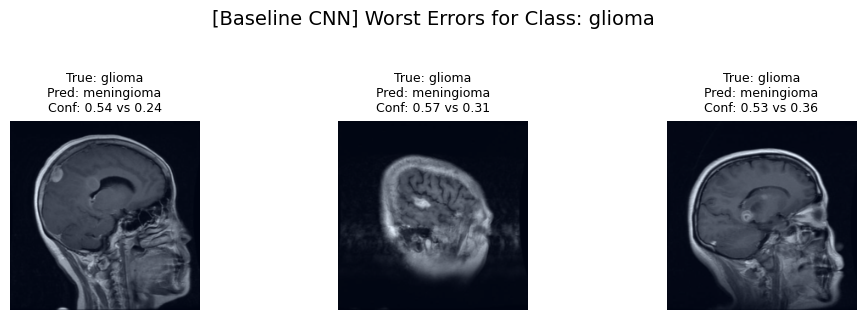

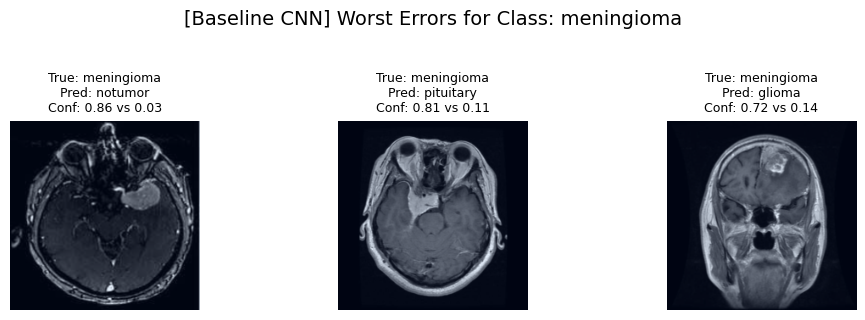

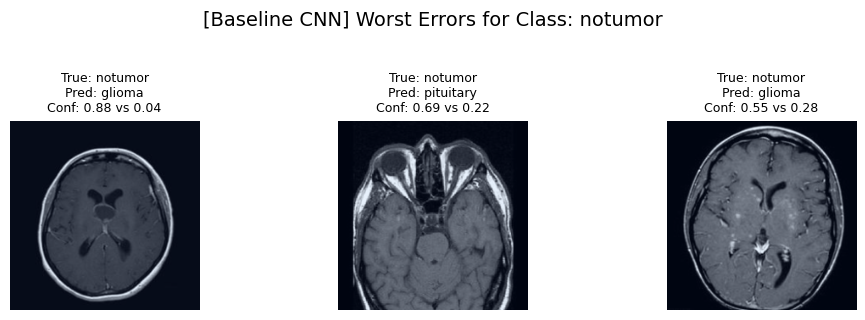

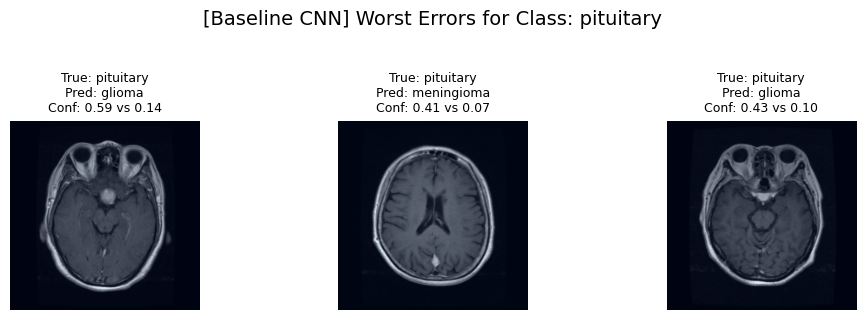


========== Analyzing Misclassifications: ResNet18 ==========


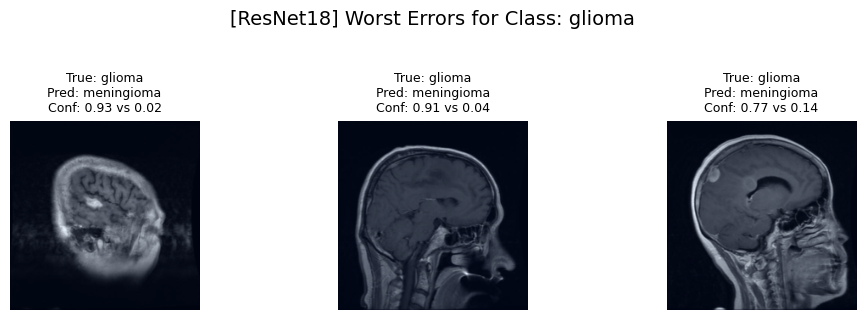

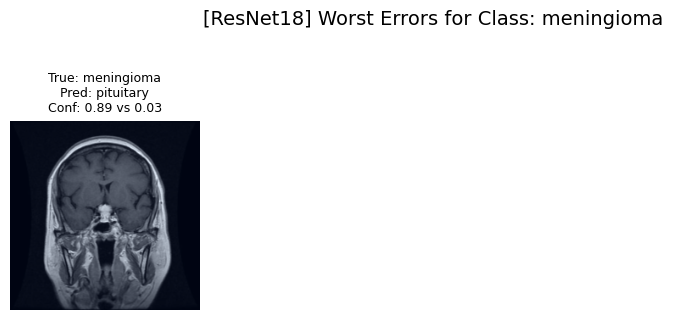

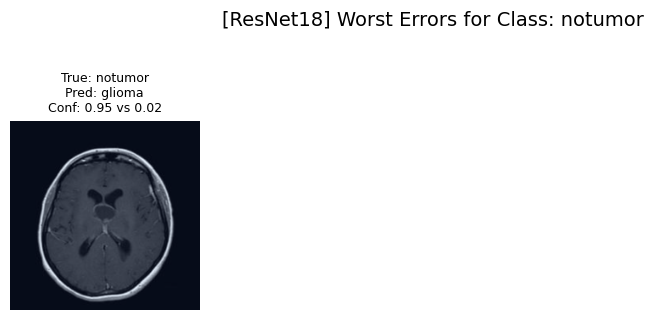

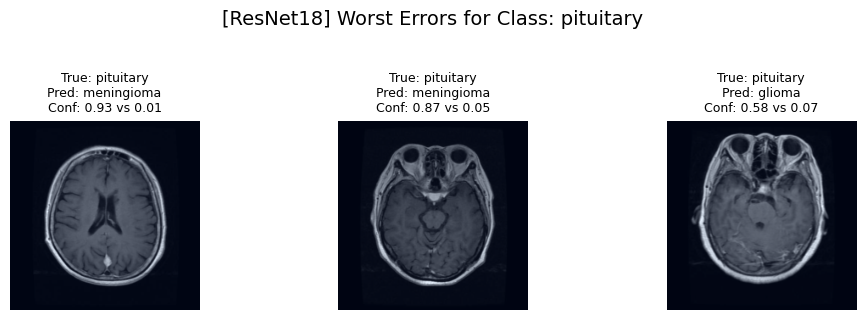

In [34]:
# 1. Get class names
class_names = train_set.classes

# 2. Visualize Baseline Errors
model_baseline.load_state_dict(torch.load('BaselineCNN_best.pth'))
visualize_errors(model_baseline, test_loader, device, class_names, model_name="Baseline CNN")

# 3. Visualize ResNet18 Errors
model_resnet.load_state_dict(torch.load('ResNet18_best.pth'))
visualize_errors(model_resnet, test_loader, device, class_names, model_name="ResNet18")